In [28]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector, Operator, partial_trace
import matplotlib.pyplot as plt
from itertools import combinations

# Full Sudoku

A **Sudoku puzzle** is defined as an $n^2 \times n^2 $ grid, where each cell must contain an integer value from the set $\{1, 2, \dots, n^2\}$. The grid is conceptually partitioned into an $n \times n $ array of smaller **subgrids**, each of size $n \times n $. The defining constraint of the puzzle is that every integer from $1$ to $2$ must appear **exactly once** in each row, each column, and each subgrid. These conditions ensure a unique and balanced distribution of values across the entire grid, establishing Sudoku as a well-defined combinatorial constraint problem.

This formulation generalizes the standard Sudoku puzzle. The classical version, commonly known as the **$9 \times 9$ Sudoku**, corresponds to $ n = 3 $, where the grid is composed of nine $3 \times 3 $ subgrids, and the digits $1$ through $9$ are used. Despite its apparent simplicity, the $9 \times 9$ Sudoku exhibits a rich mathematical structure, offering a variety of symmetry properties, constraint interactions, and computational challenges that make it a useful benchmark for optimization and logical reasoning algorithms.

The **smallest non-trivial case** occurs when $n = 2$, yielding a $4 \times 4 $ Sudoku grid. In this simplified version, the grid is populated using the digits $1, 2, 3,$ and $4$. Each digit must occur once per row, column, and $2 \times 2$ subgrid, maintaining the same logical constraints as the larger variant. This smaller system serves as an effective conceptual and computational model for studying Sudoku’s structure without the exponential growth in complexity associated with larger grids.

To facilitate systematic representation and computational manipulation, the positions within the $4 \times 4 $ Sudoku grid can be indexed numerically as follows:

$$
\left[\begin{array}{cc|cc}
0 & 1 & 2 & 3 \\
4 & 5 & 6 & 7 \\
\hline
8 & 9 & 10 & 11 \\
12 & 13 & 14 & 15
\end{array}\right]
$$

This indexing scheme provides a convenient framework for algorithmic implementations, enabling each cell to be uniquely identified by a single numerical index. Such a representation is particularly advantageous in **computational and quantum formulations** of Sudoku, where constraints are expressed algebraically or encoded within a state space. For example, in a quantum computing context, each cell can correspond to a quantum register or qubit system, and the Sudoku constraints can be represented as **projector operators** or **Hamiltonian terms** that enforce valid configurations. This encoding allows the use of **quantum optimization algorithms**—such as the Quantum Approximate Optimization Algorithm (QAOA) or Grover’s search—to explore the solution space efficiently. Consequently, the Sudoku problem serves not only as a recreational logic puzzle but also as a meaningful case study for testing and evaluating computational paradigms in constraint satisfaction and quantum information processing.


In [29]:
class SudoPuzz:
    def __init__(self, n, Nq, Sq, Vec, RR, CC, GG, U):
        self.n   = n       #Puzz size#
        self.Vec = Vec     #Puzz in an array#
        self.Sq  = Sq      #Square array of the Puzz#
        self.GG  = GG      #Puzz Grids#
        self.RR  = RR      #Puzz Rows# 
        self.CC  = CC      #Puzz Columns#     
        self.U   = U       #Puzz Unknowns#      
        self.Nq  = Nq      #No. of qubits#
        
    def Known(self, z):
        assert self.Vec[z]>-1, "Unknowns"
        return f"{self.Vec[z]:0{self.Nq}b}";
        
    def Rows(self, UKG=True):
        r = np.where(self.Sq<0)[0];
        counter = np.unique(r);
        UKG and print("Unknown Rows: ", counter + 1)
        return counter
        
    def Columns(self, UKG=True):
        c = np.where(self.Sq<0)[1];
        counter = np.unique(c);
        UKG and print("Unknown Columns: ", counter + 1)
        return counter
        
    def Grid(self, UKG=True):
        counter = np.unique([np.where(self.GG == self.U[j])[0] for j in range(len(self.U))]);
        UKG and print("Grids: ", counter + 1);
        return counter
        
    def Qind(self, z):
        assert self.Vec[z]<0, "No qubits for Knowns"
        counter = np.where(self.U==z)[0][0]
        return [self.Nq*counter+j for j in range(self.Nq)]
        
def Inputs(InputPuzz, n):                    #Validate input, compute indexing and unknowns, return SudoPuzz#
        
        assert InputPuzz.ndim==2 and InputPuzz.shape[0]==n**2 and InputPuzz.shape[1]==n**2, "Puzz Inputs Checks"
        assert np.all((InputPuzz >= 0)) and np.all((InputPuzz <= n**2)), "Inputs Must be 0 to n^2"
        InputPuzz -= 1;                                                                             #known 0..n^2-1, unknown -> -1#
        PuzzVec = InputPuzz.reshape(-1);                                                            #Puzz in 1D array#
        RRows  = [ [n**2 *  r + c             for c in range(n**2)] for r in range(n**2)];          #coordinates of rows#
        CCols  = [ [n**2 *  r + c             for r in range(n**2)] for c in range(n**2)];          #coordinates of columns#
        GGrids = [ [n**2 * (r + j) + (c + jj) for j in range(n) for jj in range(n)] for r in range(0,n**2,n) for c in range(0,n**2,n)];
                                                                                                    #coordinates of G in Vec array#
        Nq = np.ceil(np.log2(n**2)).astype(int);                                                    #Number of qubits for Uknowns#
        print("qubits for Uknowns: ", Nq)        
        UUK = np.where(PuzzVec < 0)[0]                                                              #coordinates of Uknowns#
        NQ = Nq*len(UUK);
        print(len(UUK), "Uknowns: ", UUK);
        print("No. of needed qubits: ", NQ)
        
        for j in range(n**2):                                                         #sanity checks for inputs and duplicates among knowns#
            R = PuzzVec[RRows[j]]
            C = PuzzVec[CCols[j]]
            G = PuzzVec[GGrids[j]]
            assert len(R[R>-1])==len(np.unique(R[R>-1])), f"Error in row {j}"
            assert len(C[C>-1])==len(np.unique(C[C>-1])), f"Error in column {j}"
            assert len(G[G>-1])==len(np.unique(G[G>-1])), f"Error in grid {j}"
            
        return SudoPuzz(n = n, Nq = Nq, Sq = InputPuzz, Vec = PuzzVec, RR = RRows, CC = CCols, GG = GGrids, U = UUK)

## Initiating

To define the initial configuration of the Sudoku puzzle, the following input parameters must be specified:

1. **Specify the puzzle order (`N`)**  
   Provide the integer value of `N`, which determines both the structure and the difficulty level of the puzzle.  
   - The complete Sudoku grid will have dimensions $ n^2 \times n^2 $.  
   - For instance, `N = 2` corresponds to a 4×4 (mini Sudoku) puzzle, while `N = 3` corresponds to a standard $ 9 \times 9 $ Sudoku.

2. **Assign known cell values**  
   Input the given (predefined) numbers into the variable `Inputs`.  
   - Each entry should be an integer between $1$ and $n^2 $, representing the known digits of the puzzle.  
   - These predefined numbers serve as the initial clues used by the solving algorithm or player.

3. **Represent unknown cells**  
   Any cell whose value is not known or provided should be entered as `0` within `Inputs`.  
   - The zeros act as placeholders, indicating positions where the algorithm must determine valid digits according to the Sudoku constraints.


In [30]:
N = 2; 

InputPuzz = np.array([[ 1 , 0 , 3 , 4 ],
                         [ 3 , 4 , 1 , 2 ],
                         [ 2 , 1 , 4 , 3 ],
                         [ 4 , 3 , 0 , 1]]);  

Puzz = Inputs(InputPuzz, N);

qubits for Uknowns:  2
2 Uknowns:  [ 1 14]
No. of needed qubits:  4


## State Preparation

In the context of the quantum formulation of Sudoku, each cell with an **unknown value** is represented by a set of qubits capable of encoding all possible numerical entries for that cell. Specifically, if the puzzle is of order $n$, then each cell can take values in the range $0$ to $n^2 - 1 $. To represent these possibilities in binary form, we assign  
$$
q \equiv \lceil \log_2 (n^2) \rceil
$$

qubits per unknown cell, where each qubit corresponds to one binary digit of the encoded number.  

For a puzzle with $x$ unknown entries, this encoding requires a total of $qx$ qubits in the main quantum circuit. In the extreme case where the Sudoku puzzle contains no predefined values (i.e., all entries are unknown), the total number of **puzzle qubits** reaches $qn^4 $.

The **state preparation** phase of Grover’s search algorithm involves initializing these puzzle qubits into an **equal superposition** of all computational basis states. This ensures that the initial quantum state represents a uniform mixture of all possible candidate solutions, providing a foundation for Grover’s amplitude amplification process to selectively enhance valid solutions.

Mathematically, this is achieved by applying a Hadamard gate to each qubit:

$$
|0\rangle^{\otimes N} \xrightarrow{H^{\otimes N}} \frac{1}{\sqrt{2^N}} \sum_{i=0}^{2^N - 1} |i\rangle,
$$

where $N = qx$ denotes the total number of puzzle qubits.  

The resulting **preparation circuit** exhibits a depth of $\mathcal{O}(1)$, since the Hadamard gates on individual qubits can be applied in parallel. Consequently, this stage requires only a single layer of gates, regardless of the total number of qubits involved, making it computationally efficient and scalable for larger Sudoku instances.


In [31]:
def Initial_Qubit(Puzz, UKG=False):                                                   #Generating the Circuit#
    NQ = Puzz.Nq*len(Puzz.U);                                                         #No. of qubits for Uknowns#
    UKG and print("No. of needed qubits: ", NQ);
    Puzz_qr = QuantumRegister(size = NQ, name = "Puzz");
    Puzz_qc = QuantumCircuit(Puzz_qr, name = "Qubit Prep");                           #Creating the Circuit#
    Puzz_qc.h(Puzz_qr);                                                               #Applying Hamiltonian#
    UKG and print(Puzz_qc.draw());                                                    #Drawing the Circuit#
    return Puzz_qc.to_gate();

In [32]:
Initial_Circ = Initial_Qubit(Puzz, UKG=True);

No. of needed qubits:  4
        ┌───┐
Puzz_0: ┤ H ├
        ├───┤
Puzz_1: ┤ H ├
        ├───┤
Puzz_2: ┤ H ├
        ├───┤
Puzz_3: ┤ H ├
        └───┘


## Oracle

The **Oracle** in Grover’s algorithm serves as the mechanism that marks (i.e., phase-flips) the computational basis states corresponding to valid solutions of the given problem.  
In the context of the Sudoku puzzle, the oracle must determine, for each quantum state representing a possible configuration of the unknown cells, whether that configuration satisfies all puzzle constraints. Specifically, the oracle identifies valid states by verifying that all rows, columns, and subgrids obey the uniqueness condition — that is, each digit appears exactly once within each structural unit of the puzzle.

Formally, for a grid of size $n^2 \times n^2 $, the oracle must perform up to $3n^2$ validity checks: one for each row, one for each column, and one for each subgrid.  
Each of these checks involves comparing every pair of values within the respective set, requiring up to $\frac{n^2 (n^2 - 1)}{2}$ inequality verifications.  
The complexity of the oracle, therefore, arises primarily from this combinatorial growth of pairwise comparisons across all constraints.

To implement this validation process quantum mechanically, the oracle can be decomposed into three fundamental subroutines:

1. **Value Mapping:**  
   A procedure for temporarily mapping the known (fixed) puzzle entries onto ancillary qubits to enable comparison with unknown (variable) entries.  
   This is achieved by encoding each known value in binary form and applying a series of $X$ gates to the corresponding ancilla qubits representing binary 1’s.  
   Once the comparison operation for a particular position is complete, the ancillas must be uncomputed (i.e., reset) to maintain reversibility.  
   - **Resource scaling:** acts on $q \sim \mathcal{O}(\log_2 n)$ qubits with a circuit depth of $1 \sim \mathcal{O}(1)$.

2. **Digit-wise Comparison:**  
   To determine whether two encoded digits are identical, we can employ a simple comparator circuit using controlled-NOT ($CX$) gates. Two consecutive $CX$ operations on a target qubit result in a flip only when the two compared bits differ, effectively encoding a binary inequality check.  
   - **Resource scaling:** acts on $3q \sim \mathcal{O}(\log_2 n)$ qubits with a circuit depth of $2 \sim \mathcal{O}(1)$.

3. **Logical Aggregation (`OR` operation):**  
   After comparing all digit pairs, the circuit must determine whether **at least one** of these pairwise comparisons indicates inequality.  
   This logical `OR` function can be realized using a sequence of multi-controlled $X$ ($MCX$) gates and standard $X$ gates operating on progressively larger sets of qubits.  
   The first occurrence of a logical `1` among the inputs triggers the flipping of an output qubit, and that triggering bit is subsequently inverted to prevent multiple activations.  
   - **Resource scaling:** acts on $q + 1 \sim \mathcal{O}(\log_2 n)$ qubits with a circuit depth of $ 2q \sim \mathcal{O}(\log_2 n)$.

Collectively, these three components enable the oracle to systematically identify all valid Sudoku configurations within the quantum register. Once a valid configuration is detected, its corresponding amplitude undergoes a phase inversion. This selective phase marking allows Grover’s diffusion operator, applied later in the algorithm, to amplify the probability amplitude of valid solutions and suppress invalid ones.

---


In [33]:
def Initial_Ancilla(Puzz, z, UKG=False):
    assert Puzz.Vec[z]>-1, "Assigning Knowns to Ancillas"
    QuReg = AncillaRegister(size=Puzz.Nq, name = "Anc");
    QuCirc = QuantumCircuit(QuReg, name = f"Ancilla Map {Puzz.Vec[z]}");
    DG = Puzz.Known(z);  
    Puzz.Vec[z]>0 and QuCirc.x([QuReg[k] for k,bit in enumerate(DG) if bit=='1']);    #Flipping Ancillas#
    UKG and print(QuCirc.draw());                                                     #Drawing the Circuit#
    return QuCirc.to_gate();

def DG_Comp(Puzz, UKG=False):                                                         #Generating qubits for Digits Comparison#
    DG1_qr = QuantumRegister(size=Puzz.Nq, name = "DG1"); 
    DG2_qr = QuantumRegister(size=Puzz.Nq, name = "DG2");
    DGA_qr = AncillaRegister(size=Puzz.Nq, name = "DGA"); 
    QuCirc = QuantumCircuit(DG1_qr, DG2_qr, DGA_qr, name = "Digit Compare");   
    for i in range(Puzz.Nq):                                                          #Flipping Ancilla in case Digits are not the same#
        QuCirc.cx(DG1_qr[i], DGA_qr[i]);
        QuCirc.cx(DG2_qr[i], DGA_qr[i]);                                              
    UKG and print(QuCirc.draw());
    return QuCirc.to_gate();

def OR_Circ(Puzz, UKG=False):                                                         #Generating qubit for OR logic#
    DGA_qr = AncillaRegister(size=Puzz.Nq, name = "DGA");
    DGT_qr = AncillaRegister(size=1, name = "DGT");                                   #Target#
    QuCirc = QuantumCircuit(DGA_qr, DGT_qr, name = "OR");
    for i in range(Puzz.Nq-1):                                                        #Flipping Target#
        QuCirc.mcx(DGA_qr[:(i+1)], DGT_qr[0]);
        QuCirc.x(DGA_qr[i]);
    QuCirc.mcx(DGA_qr, DGT_qr[0]);
    QuCirc.x(DGA_qr[:-1]);
    UKG and print(QuCirc.draw());                                                     #Drawing the Circuit#
    return QuCirc.to_gate();

In [34]:
Initial_Ancilla(Puzz, 2, UKG=True);
print("Circuit to compare equality of digits")
DG_Comp(Puzz, UKG=True);
print("Circuit to compute if any of a set of qubits is 1")
OR_Circ(Puzz, UKG=True);

       ┌───┐
Anc_0: ┤ X ├
       └───┘
Anc_1: ─────
            
Circuit to compare equality of digits
                           
DG1_0: ──■─────────────────
         │                 
DG1_1: ──┼────■────────────
         │    │            
DG2_0: ──┼────┼────■───────
         │    │    │       
DG2_1: ──┼────┼────┼────■──
       ┌─┴─┐  │  ┌─┴─┐  │  
DGA_0: ┤ X ├──┼──┤ X ├──┼──
       └───┘┌─┴─┐└───┘┌─┴─┐
DGA_1: ─────┤ X ├─────┤ X ├
            └───┘     └───┘
Circuit to compute if any of a set of qubits is 1
            ┌───┐     ┌───┐
DGA_0: ──■──┤ X ├──■──┤ X ├
         │  └───┘  │  └───┘
DGA_1: ──┼─────────■───────
       ┌─┴─┐     ┌─┴─┐     
  DGT: ┤ X ├─────┤ X ├─────
       └───┘     └───┘     


## Full Oracle Function in Quantum Sudoku

The complete oracle function systematically iterates over all rows, columns, and subgrids within the Sudoku grid that contain one or more missing values. For a grid of size $n \times n$, there can be up to $3n^2$ such regions (accounting for all rows, columns, and subgrids).  

Within each of these regions, the oracle evaluates all pairwise combinations of values to ensure that no digit is repeated. Specifically, for a region containing $n^2$ cells, there are $\frac{n^4 - n^2}{2}$ pairwise inequalities that must be checked. Each inequality compares either:  

1. The digits corresponding to **unknown puzzle qubits**, or  
2. Digits that have been **mapped onto ancilla qubits** for cells with known values.  

The oracle performs a conditional phase flip on the computational basis states that satisfy **all pairwise inequality constraints** within a given row, column, or subgrid. This ensures that valid solutions acquire a negative phase, while invalid states remain unchanged.  

To maintain reversibility and prepare for subsequent operations, the oracle **uncomputes** the auxiliary computations after each inequality check or after processing each row, column, or subgrid. This step resets the ancilla qubits to their initial state, allowing them to be safely reused in the next iteration of the oracle.  

In summary, the oracle implements a comprehensive verification of the Sudoku constraints in a fully reversible quantum circuit, enabling it to mark valid solution states for amplitude amplification in Grover's algorithm.


In [35]:
def Oracle_QCirc(Puzz, UKG=False):                                                    #Generating Oracle Circuit#
    Rows    = Puzz.Rows(UKG); 
    Columns = Puzz.Columns(UKG);
    Grid    = Puzz.Grid(UKG);
    Nq      = Puzz.Nq;
    NQ      = Nq*len(Puzz.U);                                                         #No. of qubits for Uknowns#
    Puzz_qr = QuantumRegister(size=NQ, name = "Puzz");
    UKG and print("No. of qubits for Uknowns: ", NQ)
    Na      = Nq;                                                                     #No. of qubits for Knowns#
    ANC_qr  = AncillaRegister(size=Na, name = "Anc");
    UKG and print("No. of Ancillas for Knowns: ", Na)
    Nc      = int(Nq + (Puzz.n**4-Puzz.n**2)/2);                                      #No. of qubits for Comparring Digits#
    DGA_qr  = AncillaRegister(size=Nc, name = "DGA");
    UKG and print("No. of qubits for Comparring Digits : ", Nq ," + ", Nc-Nq)
    Nr      = len(Rows) + len(Columns) + len(Grid);                                   #No. of qubits for Rows/Columns/Grid#
    Res_qr  = AncillaRegister(size=Nr, name = "Res");
    UKG and print("No. of qubits for Rows/Columns/Grid: ", Nr)
    N_tot   = NQ + Na + Nc + Nr;                                                      #Total no. of qubits#
    print("\n Total no. of qubits: ", N_tot)
    Oracle_qc = QuantumCircuit(Puzz_qr, ANC_qr, DGA_qr, Res_qr, name = "Oracle");
    DG_QComp  = DG_Comp(Puzz);                                                        #Comparing Puzz values#
    OR_gate   = OR_Circ(Puzz);

    N_iter = 0;                                                                       #No. of Iteration#
    
    for r in Rows:
        R = Puzz.RR[r];    
        
        for t, (X,Y) in enumerate(list(combinations(R,2))):
            Z1 = Puzz.Vec[X];                                                         #Checking Rows Values#
            Z2 = Puzz.Vec[Y];
            
            if Z1>-1 and Z2>-1:                                                       #If both are Knowns#
                Oracle_qc.x(DGA_qr[t]);                                               #Flipping#
                    
            elif Z1<0 and Z2<0:                                                       #If both are Uknowns#
                I = Puzz.Qind(X);                                                     #Finding qubits#
                J = Puzz.Qind(Y);
                
                Oracle_qc.compose(DG_QComp, qubits=(*[Puzz_qr[i] for i in I], *[Puzz_qr[i] for i in J],*DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                Oracle_qc.compose(DG_QComp, qubits=(*[Puzz_qr[i] for i in I], *[Puzz_qr[i] for i in J],*DGA_qr[-Nq:]), inplace=True);
                                                                                      #Composing Oracle#
            
            elif Z1>-1 and Z2<0:                                                      #If first value is Known#

                Anc_Map = Initial_Ancilla(Puzz, X);                                   #Mapping Known value to Ancilla#
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);

                J = Puzz.Qind(Y);                                                     #Finding qubits#
    
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);              #No Computing for Ancillas#
                        
            elif Z1<0 and Z2>-1:                                                      #If second value is Known#
                Anc_Map = Initial_Ancilla(Puzz, Y);                                   #Mapping Known value to Ancilla#
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);

                J = Puzz.Qind(X);                                                     #Finding qubits#
    
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);

        Oracle_qc.mcx(DGA_qr[:(Nc-Nq)], Res_qr[N_iter]);                              #Flipping if everything is satisfied#

        N_iter+=1;                                                                    #First Check Complete#

        for t, (X,Y) in enumerate(list(combinations(R,2))):                           #Redoing Rows Check#
            Z1 = Puzz.Vec[X];
            Z2 = Puzz.Vec[Y];
            
            if Z1>-1 and Z2>-1: 
                Oracle_qc.x(DGA_qr[t]); 
                    
            elif Z1<0 and Z2<0:

                I = Puzz.Qind(X);
                J = Puzz.Qind(Y);
                
                Oracle_qc.compose(DG_QComp, qubits=(*[Puzz_qr[i] for i in I], *[Puzz_qr[i] for i in J],*DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                Oracle_qc.compose(DG_QComp, qubits=(*[Puzz_qr[i] for i in I], *[Puzz_qr[i] for i in J],*DGA_qr[-Nq:]), inplace=True);
                        
            elif Z1>-1 and Z2<0: 
                Anc_Map = Initial_Ancilla(Puzz, X);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);


                J = Puzz.Qind(Y);
    
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);
                        
            elif Z1<0 and Z2>-1: 
                Anc_Map = Initial_Ancilla(Puzz, Y);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);

                J = Puzz.Qind(X);
    
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);
    
    for c in Columns:                                                                 #Checking Columns Values#
        C = Puzz.CC[c];
        
        for t, (X,Y) in enumerate(list(combinations(C,2))):
            Z1 = Puzz.Vec[X];
            Z2 = Puzz.Vec[Y];
            
            if Z1>-1 and Z2>-1: 
                Oracle_qc.x(DGA_qr[t]); 
                    
            elif Z1<0 and Z2<0: 
                I = Puzz.Qind(X);
                J = Puzz.Qind(Y);

                Oracle_qc.compose(DG_QComp, qubits=(*[Puzz_qr[i] for i in I], *[Puzz_qr[i] for i in J],*DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                Oracle_qc.compose(DG_QComp, qubits=(*[Puzz_qr[i] for i in I], *[Puzz_qr[i] for i in J],*DGA_qr[-Nq:]), inplace=True);
                        
            elif Z1>-1 and Z2<0: 

                Anc_Map = Initial_Ancilla(Puzz, X);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);


                J = Puzz.Qind(Y);
    
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                

                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);
                        
            elif Z1<0 and Z2>-1: 
                Anc_Map = Initial_Ancilla(Puzz, Y);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);

                J = Puzz.Qind(X);
    
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);

        Oracle_qc.mcx(DGA_qr[:(Nc-Nq)], Res_qr[N_iter]);

        N_iter+=1;                                                                     #First Check Complete#
        
        for t, (X,Y) in enumerate(list(combinations(C,2))):
            Z1 = Puzz.Vec[X];
            Z2 = Puzz.Vec[Y];
            
            if Z1>-1 and Z2>-1:
                Oracle_qc.x(DGA_qr[t]); 
                    
            elif Z1<0 and Z2<0: 
                I = Puzz.Qind(X);
                J = Puzz.Qind(Y);
                Oracle_qc.compose(DG_QComp, qubits=(*[Puzz_qr[i] for i in I], *[Puzz_qr[i] for i in J],*DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                Oracle_qc.compose(DG_QComp, qubits=(*[Puzz_qr[i] for i in I], *[Puzz_qr[i] for i in J],*DGA_qr[-Nq:]), inplace=True);
                        
            elif Z1>-1 and Z2<0:

                Anc_Map = Initial_Ancilla(Puzz, X);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);

                J = Puzz.Qind(Y);
    
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);
                        
            elif Z1<0 and Z2>-1: 
                Anc_Map = Initial_Ancilla(Puzz, Y);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);

                J = Puzz.Qind(X);
    
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);      
    
    for g in Grid:                                                                    #Checking Grid Values#
        G = Puzz.GG[g];
        
        for t, (X,Y) in enumerate(list(combinations(G,2))):
            Z1 = Puzz.Vec[X];
            Z2 = Puzz.Vec[Y];
            
            if Z1>-1 and Z2>-1:  
                Oracle_qc.x(DGA_qr[t]); 
                    
            elif Z1<0 and Z2<0: 
                I = Puzz.Qind(X);
                J = Puzz.Qind(Y);

                Oracle_qc.compose(DG_QComp, qubits=(*[Puzz_qr[i] for i in I], *[Puzz_qr[i] for i in J],*DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                Oracle_qc.compose(DG_QComp, qubits=(*[Puzz_qr[i] for i in I], *[Puzz_qr[i] for i in J],*DGA_qr[-Nq:]), inplace=True);
                        
            elif Z1>-1 and Z2<0:  
                Anc_Map = Initial_Ancilla(Puzz, X);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);

                J = Puzz.Qind(Y);
    
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);
                        
            elif Z1<0 and Z2>-1: 
                Anc_Map = Initial_Ancilla(Puzz, Y);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);

                J = Puzz.Qind(X);
    
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);   

        Oracle_qc.mcx(DGA_qr[:(Nc-Nq)], Res_qr[N_iter]);

        N_iter+=1;                                                                     #First Check Complete#
        
        for t, (X,Y) in enumerate(list(combinations(G,2))):
            Z1 = Puzz.Vec[X];
            Z2 = Puzz.Vec[Y];
            
            if Z1>-1 and Z2>-1: 
                Oracle_qc.x(DGA_qr[t]); 
                    
            elif Z1<0 and Z2<0: 
                I = Puzz.Qind(X);
                J = Puzz.Qind(Y);

                Oracle_qc.compose(DG_QComp, qubits=(*[Puzz_qr[i] for i in I], *[Puzz_qr[i] for i in J],*DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                Oracle_qc.compose(DG_QComp, qubits=(*[Puzz_qr[i] for i in I], *[Puzz_qr[i] for i in J],*DGA_qr[-Nq:]), inplace=True);
                        
            elif Z1>-1 and Z2<0:   
                Anc_Map = Initial_Ancilla(Puzz, X);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);

                J = Puzz.Qind(Y);
    
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);
                        
            elif Z1<0 and Z2>-1: 
                Anc_Map = Initial_Ancilla(Puzz, Y);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);

                J = Puzz.Qind(X);
    
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(OR_gate, qubits=(*DGA_qr[-Nq:], DGA_qr[t]), inplace=True);
                
                Oracle_qc.compose(DG_QComp, qubits=(*ANC_qr, *[Puzz_qr[i] for i in J], *DGA_qr[-Nq:]), inplace=True);
                Oracle_qc.compose(Anc_Map, qubits=ANC_qr, inplace=True);    

    Oracle_qc.mcp(np.pi, Res_qr[:-1], Res_qr[-1]);
    UKG and print(Oracle_qc.draw())
    
    return Oracle_qc.to_gate()

In [36]:
Oracle_Circ = Oracle_QCirc(Puzz, UKG=True)

Unknown Rows:  [1 4]
Unknown Columns:  [2 3]
Grids:  [1 4]
No. of qubits for Uknowns:  4
No. of Ancillas for Knowns:  2
No. of qubits for Comparring Digits :  2  +  6
No. of qubits for Rows/Columns/Grid:  6

 Total no. of qubits:  20
                          ┌────────────────┐       ┌────────────────┐»
Puzz_0: ──────────────────┤2               ├───────┤2               ├»
                          │                │       │                │»
Puzz_1: ──────────────────┤3               ├───────┤3               ├»
                          │                │       │                │»
Puzz_2: ──────────────────┤                ├───────┤                ├»
                          │                │       │                │»
Puzz_3: ──────────────────┤                ├───────┤                ├»
        ┌────────────────┐│                │       │                │»
 Anc_0: ┤0               ├┤0               ├───────┤0               ├»
        │  Ancilla Map 0 ││                │       │    

## Diffuser

The Grover diffusion operator, or diffuser, is a central component of Grover's search algorithm. For a system of $N$ qubits, the standard diffuser circuit is expressed as:

$$
D = \left( H^{\otimes N} \right) \left( X^{\otimes N} \right) \left( C^{N-1}Z \right) \left( X^{\otimes N} \right) \left( H^{\otimes N} \right),
$$

where $H$ denotes the Hadamard gate, $X$ the Pauli-X gate, and $C^{N-1}Z$ an $(N-1)$-controlled Z gate.

This operator performs an inversion about the mean of the amplitude distribution of the quantum state. After the oracle has marked the valid solution states by inverting their phases, the mean of the amplitudes shifts such that the inversion about the mean effectively amplifies the amplitudes of these solution states while simultaneously suppressing the amplitudes of non-solution states.

Consequently, repeated application of the diffuser, interleaved with the oracle, systematically increases the probability of measuring a valid solution upon observation of the system.

In [37]:
Diff_Circ = Diff_QCirc(Puzz, UKG=True)

        ┌───┐┌───┐       ┌───┐┌───┐
Puzz_0: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
        ├───┤├───┤ │     ├───┤├───┤
Puzz_1: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
        ├───┤├───┤ │     ├───┤├───┤
Puzz_2: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
        ├───┤├───┤ │P(π) ├───┤├───┤
Puzz_3: ┤ H ├┤ X ├─■─────┤ X ├┤ H ├
        └───┘└───┘       └───┘└───┘


## Grover

The complete Grover search circuit is constructed by first implementing the state preparation stage, which initializes the system into a uniform superposition over all possible configurations of the Sudoku puzzle. Following this, the **oracle** and **diffusion** operators are applied in sequence to amplify the amplitudes corresponding to valid solution states. This sequence—often referred to as the **Grover iteration**—is repeated a specific number of times to maximize the probability of measuring a valid solution.

The optimal number of Grover iterations depends on the total number of states $N$ and the number of valid solutions $m$. As derived in Nielsen and Chuang (Eq. 6.17), the optimal iteration count is given by

$$
k = \left\lceil \frac{\pi}{4} \sqrt{\frac{N}{m}} \right\rceil.
$$

This expression ensures that the amplitudes of the marked (solution) states are maximally amplified, while those of non-solution states are correspondingly suppressed.

In the present case, the system comprises $N = 2^4 = 16$ possible configurations encoded by four qubits, and there exist $m = 2$ valid solutions. Substituting these values yields an optimal iteration count of

$$
k = \left\lceil \frac{\pi}{4} \sqrt{\frac{16}{2}} \right\rceil = 2.
$$

Thus, two Grover iterations—each consisting of an oracle application followed by the diffusion operator—are required to maximize the probability of successfully measuring a valid Sudoku configuration.

In practice, the full Grover circuit is implemented by combining three primary subcircuits: the **state preparation circuit**, the **oracle**, and the **diffuser**. The state preparation circuit applies Hadamard gates to all qubits, establishing a uniform superposition. The oracle is realized as a phase-flip operation conditioned on the satisfaction of the Sudoku constraints, effectively marking the solution states. The diffuser performs an inversion about the mean amplitude of the system, thereby amplifying the marked states. These components are concatenated and repeated $k = 2$ times, after which the final measurement of the four puzzle qubits yields one of the valid Sudoku configurations with high probability.

In [38]:
def Evaluation(Puzz, QuCirc):                                                         #Establishing Grover Circuit#
    Psi_Vec = Statevector(QuCirc);                                                    #Final statevector#
    Sig     = partial_trace(Psi_Vec, [j for j in range(Puzz.Nq*len(Puzz.U), QuCirc.num_qubits)]);
                                                                                      #Reduced density matrix of a Subsystem of qubits#
    P, PP   = zip(*Sig.probabilities_dict().items());                                 #Extracting Probabilities of Unknowns#
    Pbins   = [int(p,2) for p in P];              
    Fig     = plt.figure();                                                           #Plotting Probabilities#
    Axes    = Fig.add_subplot(111);
    Axes.bar(Pbins, PP);
    Axes.set_xlabel("Qubits");
    Axes.set_ylabel("Probability");
    print(Fig);

    Thres_Index  = [i for i, val in enumerate(PP) if val >= 0.95*max(PP)];            #Setting the threshold for Prob. of qubits#
    Thres_States = [P[i] for i in Thres_Index];

    Candids = [];                                                                     #Defining Candidates for Solution#
    for s in Thres_States:
        Candid = np.copy(Puzz.Vec);                                                   #Starting with the Initial Puzz#
        for j in range(len(Puzz.U)):
            p = int( s[-(1+Puzz.Nq*j):-(Puzz.Nq+1+Puzz.Nq*j):-1], 2);
            Candid[Puzz.U[j]] = p                                                     #Filling the Unknowns with Candidates#
        Candid = np.reshape(Candid+1, (Puzz.n**2, Puzz.n**2));                        #Reconstruct the Sq lattice solution#
        Candids.append(Candid);                                                       #Appending the Candidate#
        print("\n Candidate: \n", Candid )
    
    return Candids, Fig
def Diff_QCirc(Puzz, UKG=False):
    QuReg  = QuantumRegister(size=Puzz.Nq*len(Puzz.U), name = "Puzz");
    QuCirc = QuantumCircuit(QuReg, name = "Diffuser");
    QuCirc.h(QuReg);
    QuCirc.x(QuReg);
    QuCirc.mcp(np.pi, QuReg[:-1], QuReg[-1]);
    QuCirc.x(QuReg);
    QuCirc.h(QuReg);
    UKG and print(QuCirc.draw());                                                     #Drawing the Circuit#
    return QuCirc.to_gate()

def Grover_Circ(Puzz, Nt, UKG=False):                                                 #Generating Grover Circuit#
    NQ      = Puzz.Nq*len(Puzz.U);                                                    #No. of qubits for Uknowns#
    Puzz_qr = QuantumRegister(size=NQ, name = "Puzz");
    N_Anc   = Puzz.Nq;                                                                #No. of qubits for Knowns#
    Anc_qr  = AncillaRegister(size=N_Anc, name = "Anc");
    N_Comp  = int(Puzz.Nq + (Puzz.n**4-Puzz.n**2)/2);                                 #No. of qubits for Comparring Digits#
    Comp_qr = AncillaRegister(size=N_Comp, name = "Comp");
    N_RCG   = len(Puzz.Rows(UKG=False)) + len(Puzz.Columns(UKG=False)) + len(Puzz.Grid(UKG=False)); 
                                                                                      #No. of qubits for Rows/Columns/Grid#
    RCG_qr  = AncillaRegister(size=N_RCG, name = "Res");
    QuCirc  = QuantumCircuit(Puzz_qr, Anc_qr, Comp_qr, RCG_qr, name = "Grover");
    Initial_Circ = Initial_Qubit(Puzz);                                               #Initial Circuit#
    Oracle_Circ  = Oracle_QCirc(Puzz);
    Diff_Circ = Diff_QCirc(Puzz);
    QuCirc.compose(Initial_Circ, inplace=True);                                       #Initial State#
    for j in range(Nt):
        QuCirc.compose(Oracle_Circ, inplace=True);
        QuCirc.compose(Diff_Circ, inplace=True);
    UKG and print(QuCirc.draw())
    return QuCirc

**Note:** The execution of this simulation required approximately 10 minutes on a standard laptop for a quantum circuit comprising roughly 20 qubits. It is important to emphasize that the computational complexity of simulating quantum circuits grows exponentially with the number of qubits. Consequently, even modest increases in the number of qubits can lead to a substantial escalation in the required computational time and resources. This behavior reflects the inherent exponential scaling characteristic of quantum state space, where a system of $n$ qubits occupies a $2^n$-dimensional Hilbert space.


Optimal # of iterations:  2

 Total no. of qubits:  20
Figure(640x480)

 Candidate: 
 [[1 2 3 4]
 [3 4 1 2]
 [2 1 4 3]
 [4 3 2 1]]


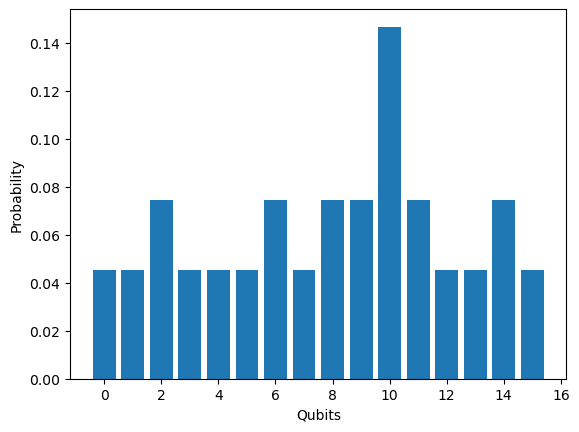

In [39]:
m = 1; N = 4;
Nt = int(np.ceil(np.pi/4 * np.sqrt(N/m))); ## N&C 6.17
print("Optimal # of iterations: ",Nt);

grover_qc = Grover_Circ(Puzz, Nt, UKG=False)

answers, histogram = Evaluation(Puzz, grover_qc);

## Acknowledgements

I would like to express my sincere gratitude to the various resources and individuals who have supported this work. First, I thank the **Qiskit documentation and community**, whose comprehensive guides and examples have been invaluable in understanding and implementing quantum circuits. I am also grateful to **ChatGPT**, which provided timely explanations, clarifications, and guidance on technical concepts throughout this project.

Additionally, I extend my appreciation to **The Erdős Institute** and its dedicated instructors, whose mentorship and instruction have greatly enhanced my understanding of complex computational and mathematical concepts. Their support has been instrumental in the successful completion of this work.
